In [25]:
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
from cutmix import CutMixCollator, CutMixCriterion

import matplotlib.pyplot as plt
%matplotlib inline

In [27]:

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.05),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

ds_path = Path('./dataset')
train_ds_path = ds_path.joinpath('train')
val_ds_path = ds_path.joinpath('val')
test_ds_path = ds_path.joinpath('test')

train_ds = datasets.ImageFolder(train_ds_path, transform=data_transforms['train'])
val_ds = datasets.ImageFolder(val_ds_path, transform=data_transforms['val'])
test_ds = datasets.ImageFolder(test_ds_path, transform=data_transforms['val'])

N_train = len(train_ds)
N_valid = len(val_ds)
N_test = len(test_ds)
total = N_train + N_valid + N_test
print(f"Training set size: {N_train} images - ({N_train/(total)*100}%)")
print(f"Valdiation set size: {N_valid} images - ({N_valid/(total)*100}%)")
print(f"Test set size: {N_valid} images - ({N_test/(total)*100}%)")

train_loader = torch.utils.data.DataLoader(train_ds,
                                           batch_size=32,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=CutMixCollator())

valid_loader = torch.utils.data.DataLoader(val_ds,
                                           batch_size=32,
                                           shuffle=True,
                                           num_workers=4)

test_loader = torch.utils.data.DataLoader(test_ds, 
                                          batch_size=32, 
                                          shuffle=True, 
                                          num_workers=4)

Training set size: 936 images - (65.0%)
Valdiation set size: 216 images - (15.0%)
Test set size: 216 images - (20.0%)


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
train_ds.class_to_idx

{'person': 0, 'robot': 1}

In [34]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(32, 16))
        ax.set_xticks([])
        ax.set_yticks([])
        images = images.permute(0, 2, 3, 1)
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        images = std * images + mean
        images = torch.clip(images, 0, 1)
        images = images.permute(0, 3, 1, 2)
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        print(labels)
        break

(tensor([1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 0, 1, 1, 0, 0]), tensor([1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0]), 0.11363672835887828)


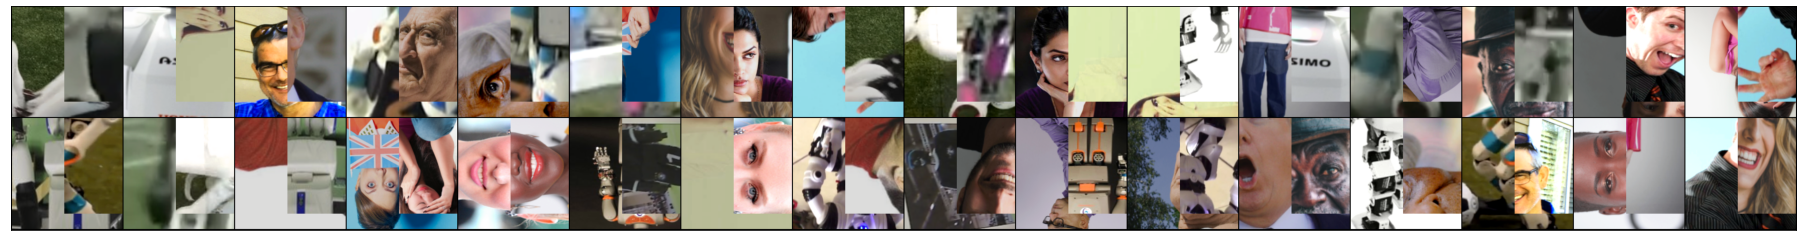

In [35]:
## show_batch(train_loader)

In [50]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels1, labels2, lam = labels
        labels = (labels1.to(device), labels2.to(device), lam)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device):
    """ Evaluating the model for either validation or test """
    correct = 0
    total = 0
    loss_list = []
    
    for images, labels in eval_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    
    return accuracy, loss


def train_model(model, optimizer, scheduler, train_criterion, valid_criterion, train_loader, valid_loader, num_epochs):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        accuracy, loss = eval_model(model=model, 
                                    eval_loader=valid_loader,
                                    criterion=valid_criterion, 
                                    device=device)
        valid_acc.append(accuracy)
        val_loss.append(loss)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(model=model, 
                                                train_loader=train_loader, 
                                                optimizer=optimizer,
                                                criterion=train_criterion, 
                                                epoch=epoch,
                                                device=device)
        scheduler.step()
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        
        if(epoch % 5 == 0 or epoch==num_epochs-1):
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
            print(f"    Accuracy: {accuracy}%")
            print("\n")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, valid_acc

In [51]:
def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

def plot_stats(train_loss, val_loss, loss_iters, valid_acc):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(24,5)

    smooth_loss = smooth(loss_iters, 31)
    ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[0].legend(loc="best")
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("CE Loss")
    ax[0].set_title("Training Progress")

    epochs = np.arange(len(train_loss)) + 1
    ax[1].plot(epochs, train_loss, c="red", label="Train Loss", linewidth=3)
    ax[1].plot(epochs, val_loss, c="blue", label="Valid Loss", linewidth=3)
    ax[1].legend(loc="best")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("CE Loss")
    ax[1].set_title("Loss Curves")

    epochs = np.arange(len(val_loss)) + 1
    ax[2].plot(epochs, valid_acc, c="red", label="Valid accuracy", linewidth=3)
    ax[2].legend(loc="best")
    ax[2].set_xlabel("Epochs")
    ax[2].set_ylabel("Accuracy (%)")
    ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc),2)}% @ epoch {np.argmax(valid_acc)+1})")

    plt.show()

# VGG-11

In [55]:
vgg_11 = models.vgg11(pretrained=True)

in_features = vgg_11.classifier[-1].in_features
layer = nn.Linear(in_features, 2)
nn.init.normal_(layer.weight, 0, 0.01)
nn.init.constant_(layer.bias, 0)
vgg_11.classifier[-1] = layer

vgg_11 = vgg_11.to(device)

In [56]:
train_criterion = CutMixCriterion()
valid_criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(vgg_11.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_loss_vgg, val_loss_vgg, loss_iters_vgg, valid_acc_vgg = train_model(
    model=vgg_11,
    optimizer=optimizer,
    scheduler=scheduler,
    train_criterion=train_criterion,
    valid_criterion=valid_criterion,
    train_loader=train_loader,
    valid_loader=valid_loader, 
    num_epochs=20
)

Epoch 1/20
    Train loss: 0.697
    Valid loss: 0.77386
    Accuracy: 34.25925925925926%


Epoch 6/20
    Train loss: 0.33388
    Valid loss: 0.11783
    Accuracy: 96.75925925925925%


Epoch 11/20
    Train loss: 0.29696
    Valid loss: 0.07249
    Accuracy: 99.07407407407408%


Epoch 16/20
    Train loss: 0.27712
    Valid loss: 0.05826
    Accuracy: 99.53703703703704%


Epoch 20/20
    Train loss: 0.2945
    Valid loss: 0.05418
    Accuracy: 99.53703703703704%


Training completed


In [57]:
torch.save(vgg_11, 'models/vgg_11.pth')

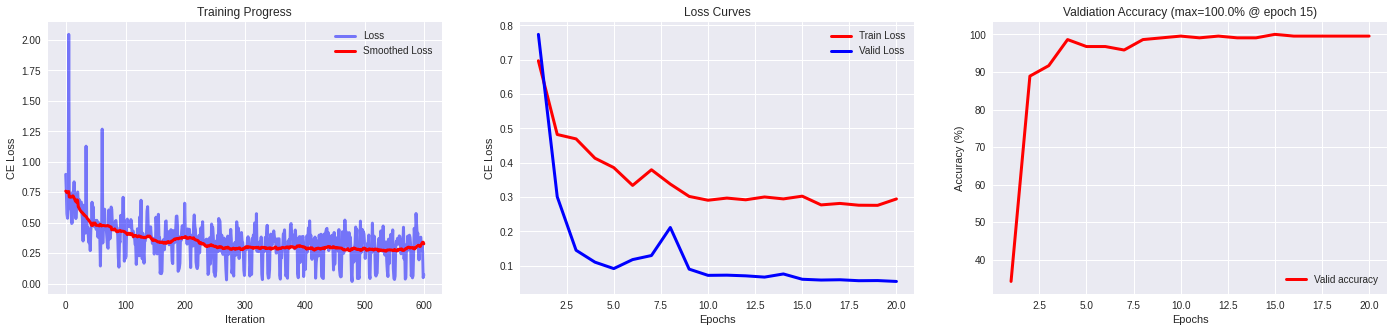

In [60]:
plot_stats(train_loss_vgg, val_loss_vgg, loss_iters_vgg, valid_acc_vgg)

As we can see, the performance of the model seems to be really good.
The accuracy is nearly 100% on the validation data.

But the loss of the validation data is significantly lower than the loss of the validation data.
This is somewhat concerning in the sense that there might be a bug in the implementation.

After rechecking the code we conclude that we have found no bugs.
Our explanation for this is that the difference is due to the fact that predicting the cutmix images is harder than predicting the real images.
Also in the visualization of the cutmix-images in the beginning, we can see that even for us humans, some of those images are ambiguous.

# ResNet 18

In [63]:
resnet_18 = models.resnet18(pretrained=True)

num_neurons = resnet_18.fc.in_features
resnet_18.fc = nn.Linear(num_neurons, 2)

resnet_18 = resnet_18.to(device)

In [69]:
train_criterion = CutMixCriterion()
valid_criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(resnet_18.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_loss_resnet, val_loss_resnet, loss_iters_resnet, valid_acc_resnet = train_model(
    model=resnet_18,
    optimizer=optimizer,
    scheduler=scheduler,
    train_criterion=train_criterion,
    valid_criterion=valid_criterion,
    train_loader=train_loader,
    valid_loader=valid_loader, 
    num_epochs=20
)

Epoch 1/20
    Train loss: 0.51008
    Valid loss: 1.21844
    Accuracy: 50.0%


Epoch 6/20
    Train loss: 0.35707
    Valid loss: 0.14758
    Accuracy: 97.68518518518519%


Epoch 11/20
    Train loss: 0.31887
    Valid loss: 0.07431
    Accuracy: 100.0%


Epoch 16/20
    Train loss: 0.29122
    Valid loss: 0.06927
    Accuracy: 100.0%


Epoch 20/20
    Train loss: 0.27296
    Valid loss: 0.06788
    Accuracy: 100.0%


Training completed


In [70]:
torch.save(resnet_18, 'models/resnet_18.pth')

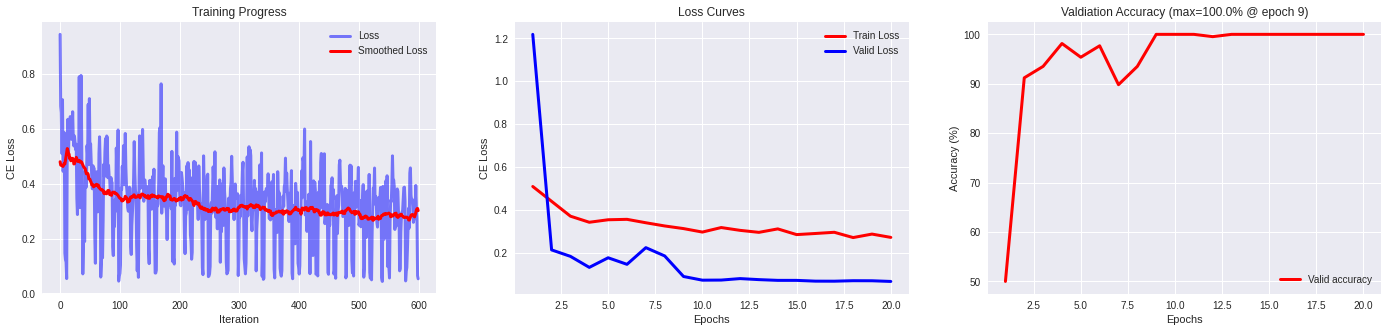

In [72]:
plot_stats(train_loss_resnet, val_loss_resnet, loss_iters_resnet, valid_acc_resnet)

Here the same pattern emerges as in VGG-11.
The accuracy is even higher in this case (100% on the validation data).

So only looking at the output one would prefer the resnet-18 model over the VGG-11 one.

Also we can see that here the difference between training and validation loss again emerges.
This again is probably due to the fact that cutmix images are sometimes ambiguous.

# DenseNet 121

In [74]:
densenet = models.densenet121(pretrained=True)

in_features = densenet.classifier.in_features
layer = nn.Linear(in_features, 2)
nn.init.constant_(layer.bias, 0)

densenet.classifier = layer

densenet = densenet.to(device)

In [75]:
train_criterion = CutMixCriterion()
valid_criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(densenet.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_loss_densenet, val_loss_densnet, loss_iters_densnet, valid_acc_densenet = train_model(
    model=densenet,
    optimizer=optimizer,
    scheduler=scheduler,
    train_criterion=train_criterion,
    valid_criterion=valid_criterion,
    train_loader=train_loader,
    valid_loader=valid_loader, 
    num_epochs=20
)

Epoch 1/20
    Train loss: 0.46155
    Valid loss: 0.80257
    Accuracy: 37.5%


Epoch 6/20
    Train loss: 0.30277
    Valid loss: 0.1239
    Accuracy: 99.53703703703704%


Epoch 11/20
    Train loss: 0.29217
    Valid loss: 0.08593
    Accuracy: 99.07407407407408%


Epoch 16/20
    Train loss: 0.29314
    Valid loss: 0.08044
    Accuracy: 98.14814814814815%


Epoch 20/20
    Train loss: 0.28975
    Valid loss: 0.08298
    Accuracy: 98.14814814814815%


Training completed


In [76]:
torch.save(densenet, 'models/densenet_121.pth')

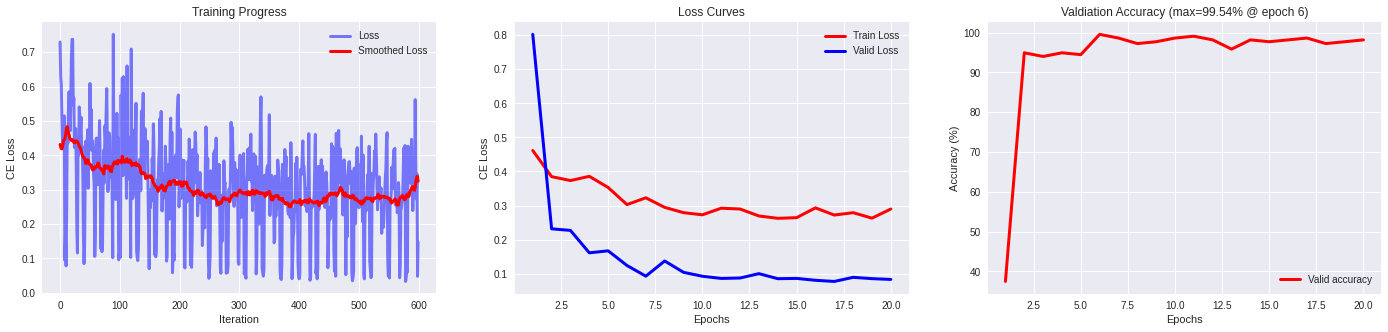

In [78]:
plot_stats(train_loss_densenet, val_loss_densnet, loss_iters_densnet, valid_acc_densenet)

DenseNet seems to perform worst of all of this models.

Tough it also has an accuracy of approximately 98% after the last epoch.

Here again the validation loss is significantly lower than the train loss after a couple of epochs.

# Results on comparing VGG-11, ResNet 18 and DenseNet 121

# TODO add accuracy of resnet

In [86]:
eval_model(resnet_18, test_loader, nn.CrossEntropyLoss(reduction='mean'), device)

(97.22222222222221, 0.12420766221152411)

Only looking at the accuracy on the validation set, we would choose our fine-tuned version of ResNet-18 as a classifier.

This has an accuracy of ??? on the test-set.

# ResNet as fixed feature extractor + MLP

One way to implement this model is to set `requires_grad=False` for all parameters and then add `nn.Sequential` for the fully-connected part of the model

In [91]:
resnet_fixed = models.resnet18(pretrained=True)
for param in resnet_fixed.parameters():
    param.requires_grad = False

in_features = resnet_fixed.fc.in_features
fc = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(512, 128),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(128, 2))
resnet_fixed.fc = fc

resnet_fixed = resnet_fixed.to(device)

In [92]:
train_criterion = CutMixCriterion()
valid_criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(resnet_fixed.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_loss_resnet_fixed, val_loss_resnet_fixed, loss_iters_resnet_fixed, valid_acc_resnet_fixed = train_model(
    model=resnet_fixed,
    optimizer=optimizer,
    scheduler=scheduler,
    train_criterion=train_criterion,
    valid_criterion=valid_criterion,
    train_loader=train_loader,
    valid_loader=valid_loader, 
    num_epochs=20
)

Epoch 1/20
    Train loss: 0.63223
    Valid loss: 0.71694
    Accuracy: 36.11111111111111%


Epoch 6/20
    Train loss: 0.44408
    Valid loss: 0.14127
    Accuracy: 99.53703703703704%


Epoch 11/20
    Train loss: 0.42913
    Valid loss: 0.14085
    Accuracy: 99.53703703703704%


Epoch 16/20
    Train loss: 0.403
    Valid loss: 0.13049
    Accuracy: 99.53703703703704%


Epoch 20/20
    Train loss: 0.41231
    Valid loss: 0.13064
    Accuracy: 99.53703703703704%


Training completed


In [93]:
 torch.save(resnet_fixed, 'models/resnet_fixed_mlp.pth')

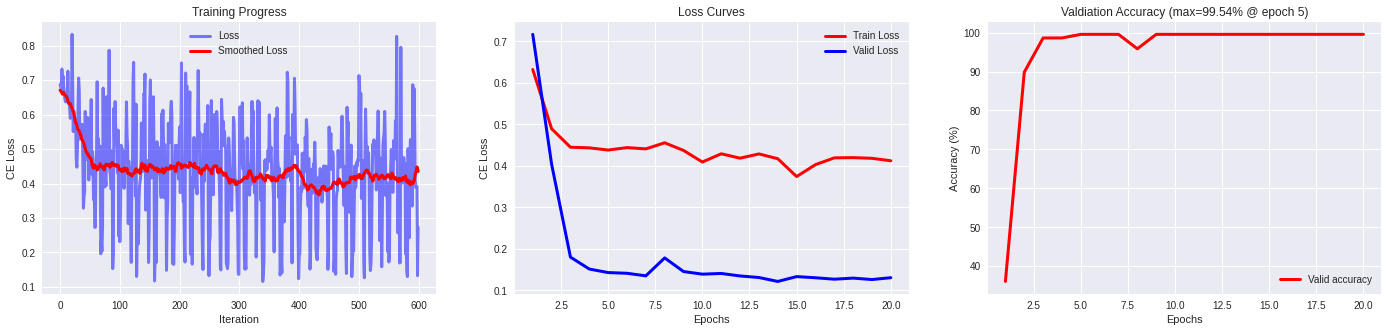

In [101]:
plot_stats(train_loss_resnet_fixed, val_loss_resnet_fixed, loss_iters_resnet_fixed, valid_acc_resnet_fixed)